In [1]:
##Preable
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import copy
import pickle
import random

from EightBitTransit.cTransitingImage import TransitingImage
from EightBitTransit.inversion import *
from EightBitTransit.misc import *

%matplotlib inline

random.seed()
tessCurves = ["364539361","148560484","150361737","151684231","167044654","176872401","177037692","179232118","183639751","260127606","279516815","294153254","339771969","364539359","38828272","391927841","410302543","78185731","78452879"]

In [2]:
def loadSignal(filename): ##Load the signal from files
    overlapTimes, planetLC = np.loadtxt("Signals/"+filename+".txt", unpack = True)
    '''
    fig, ax = plt.subplots(1,1,figsize=(24,6))##Plotting for good measure
    ax.plot(overlapTimes,planetLC)
    plt.xlabel("Time",fontsize=14)
    plt.ylabel("Flux",fontsize=14)
    plt.title(r"Signal Light Curve",fontsize=16)
    plt.show()
    '''
    return overlapTimes, planetLC

In [3]:
def loadTESSLC(filename):
    fp = open("./TESSCurves/"+filename+".pkl","rb") ##Loading the file
    data = pickle.load(fp)
    fp.close()
    
    q = data[11]==0
    times = data[6][q]
    corrlc = data[8][q]
    pcalc = data[9][q]
    
    pc = 70*np.random.random()+15 ##Generates a random percentile between 20 and 80
    midTime = np.percentile(times,pc) ##Set the 0 point at 1/3. Eight Bit Transit centers light curves at 0 so put this where you want to center the transit
    ##Tess light curves seem to have a 2 day gap near the center
    times = times - midTime

    maxpca = np.max(pcalc)
    pcaLc = pcalc/maxpca
    corrLc = corrlc/np.max(corrlc)
    '''
    fig, ax = plt.subplots(1,1,figsize=(24,6))
    ax.plot(times,normLc)
    plt.xlabel("Time",fontsize=14)
    plt.ylabel("Relative Flux",fontsize=14)
    plt.title(r"TESS 612256219 Light Curve",fontsize=16)
    plt.show()
    '''
    return times, corrLc, pcaLc, midTime



In [4]:
def extendLC(LC, overlapTimes, times): 
    ##Extends a light curve from Eight Bit Transit by adding full flux to the ends for the desired length
    ##Assumption: Maximum flux value is 1
    ##Assumption: Light curve is at maximum value at the start and end
    interval = (times[-1] - times[0])/len(times) ##Figures out long the average time between elements is
    lengthDiff = len(times) - len(overlapTimes) 
    before = int((overlapTimes[0]-times[0])/interval) ##Calculates how many points should be placed before the start of the light curve
    after = lengthDiff - before
    extendedLC = np.append(np.ones(before),LC)
    extendedLC = np.append(extendedLC,np.ones(after))
    for i in range(len(times) - 1):
        if times[i+1] - times[i] > interval and extendedLC[i] < 1:
            diff = times[i+1] - times[i]
            gap = int(diff/interval)
            extendedLC = [extendedLC[j] for j in range(len(extendedLC)) if j <= i or j > i+gap ]
            extendedLC = np.append(extendedLC,np.ones(len(times)-len(extendedLC)))
    '''
    extendedLC = np.ones(len(times))##Start with full flux curve
    overlapIndex = 0
    for i in range(len(times)):##Iterate over the desired time array
        if times[i] == overlapTimes[overlapIndex]: ##When the desired time has caught up to the light curve from ebt, use the ebt values
            if overlapIndex < len(overlapTimes) - 2:##Only do this to the end of the ebt light curve
                overlapIndex += 1
                extendedLC[i]  = LC[overlapIndex]
        
    '''
    return extendedLC, times

In [5]:
def sumLightCurves(trueLC, genLC): 
    ##Sums a true light curve and a generated lightcurve
    ##Assumptions: 1 is the maximal value for both light curves
    ##Assumption: The sum of both light curves is greater than one at every point, this can be satisfied by using a non-variable true light curve and leaving >1% as the minimum in the generated curve
    if len(trueLC) - len(genLC) != 0:
        raise Exception("Light Curves must be the same size: " + str(len(trueLC))+ "," + str(len(genLC)))
    sumLC = trueLC + genLC - 1
    ##Generated Light curve has no noise, subtracting 1 from this light curve gives reduction due to transit
    ##Preserves noise in original light curve (average would half it)
    ##Assumes min value in both light curves >0.5, anything violating this assumption is grounds for further investigation in itself 
    return sumLC

In [6]:
def injectSignal(times, normLc, overlapTimes, planetLC, midTime):
    longTransitLC, times = extendLC(planetLC, overlapTimes, times)##Extending the light curve to match the TESS curve
    sumLC = sumLightCurves(normLc, longTransitLC)##Summing and normalizing lightcurves
    times = times + midTime ##Resetting time array to original values
    '''
    fig, ax = plt.subplots(1,1,figsize=(8,6))##PLotting
    ax.plot(times,sumLC,label = "Generated Curve", ls = '-', marker = 'o', ms = 1)
    ax.legend()
    plt.xlabel("Time",fontsize=14)
    plt.ylabel("Relative flux",fontsize=14)
    plt.title(r"Summing a noisy and noiseless lightcurve",fontsize=16)

    ax.tick_params(direction = "in", which = "major", length = 8, top = True, right = True)
    ax.tick_params(direction = "in", which = "minor", length = 4, top = True, right = True)
    '''
    return times, sumLC

In [7]:
def export(filein, fileout,lookup, corrlightcurve, pcalightcurve, n,t,k, depth = 0.01, length = 1,r = 0): ##Replaces the corrected flux with the injected signal
    fp = open("./TESSCurves/"+filein+".pkl","rb") ##Loading the file
    data = pickle.load(fp)
    fp.close()
    q = data[11]==0 #Extracting the data we want, can only keep high quality data
    corrMax = np.max(data[8][q])
    pcaMax = np.max(data[9][q])
    
    i = 0
    for j in range(len(data[9])):
        if data[11][j] == 0:
            data[8][j] = corrlightcurve[i]*corrMax
            data[9][j] = pcalightcurve[i]*pcaMax
            i += 1
    data[0] = fileout
    
    
    f = open("./Output/20210622/tesslc_"+fileout+".pkl","wb")
    pickle.dump(data,f)
    f.close()
    f = open("./Output/20210622/"+lookup+".csv","a")
    f.write(fileout + ","+filein+",9,"+str(depth)+","+str(length)+","+str(n)+","+str(t)+','+str(k)+',n'+str(n)+'r'+str(r)+'v'+str(int(2/length))+'\n')
    f.close()
    

In [8]:
def cutLightCurve(times, lc, t0, t1):
    newTimes = []
    newLc = []
    for i in range(len(times)):
        if times[i] > t0 and times[i] < t1:
            newTimes.append(times[i])
            newLc.append(lc[i])
            
    return newTimes,newLc

In [10]:
for i in range(4):##Inject each of the 25 signals into a light curve
    for l in range(2):
        fig, axs = plt.subplots(7,10, figsize = (24,12))
        for j in range(7):
            for k in range(10):
                prop = prop = 0.32768 * 1.25**k
                times, corrlc, pcalc, midTime = loadTESSLC("tesslc_"+tessCurves[0])
                filename = "n"+str(i+3)+"t"+str((j+6*l)*360/12)+"k"+str(prop)
                overlapTimes, planetLC = loadSignal(filename)
                corrTimes, corrlc = injectSignal(times, corrlc, overlapTimes, planetLC, midTime)
                pcaTimes, pcalc = injectSignal(times, pcalc, overlapTimes, planetLC, midTime)
                filename = "1"+str(i+3)+"2"+str(int((j+6*l)*360/12))+"3"+str(int(100*prop))+"000000"
                #export("tesslc_"+tessCurves[0],filename,'20210610lookup',corrlc, pcalc,i+3,(j+6*l)*0/12,prop)
                overlapTimes, sumLC = cutLightCurve(pcaTimes, pcalc, midTime - 2, midTime+2)
                axs[j][k].plot(overlapTimes, sumLC)
                axs[j][k].tick_params(direction = "in", which = "major", length = 4, top = True, right = True)
                axs[j][k].tick_params(direction = "in", which = "minor", length = 2, top = True, right = True)
                #axs[i][j].axis('off')
                axs[j][k].set_xlabel("k: "+ str(prop))
                axs[j][k].set_ylabel("t: "+str((j+6*l)*180/12))
                for ax in axs.flat:
                    ax.label_outer()
        fig.suptitle("Lightcurves for dataset 20210610, n: "+str(i+3), fontsize = 16)
        #fig.savefig("DataVisualization/20210610/n"+str(i+3)+"lcsb.png")
        plt.show()
    

KeyboardInterrupt: 

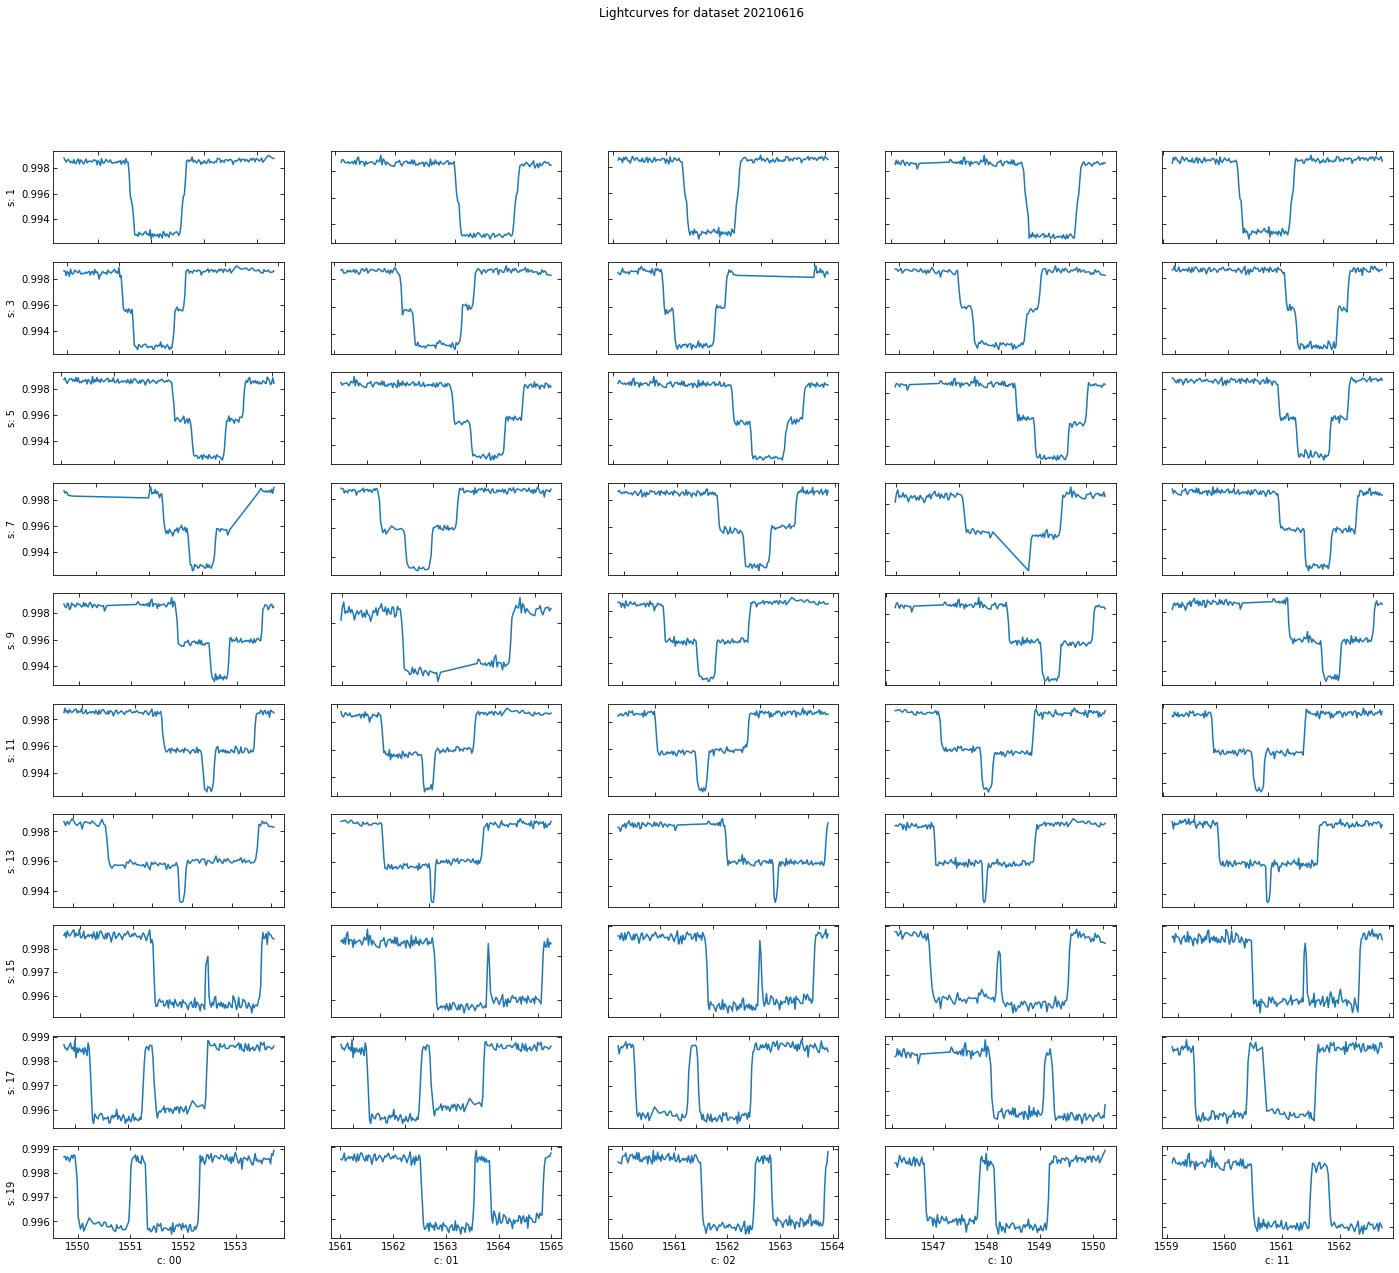

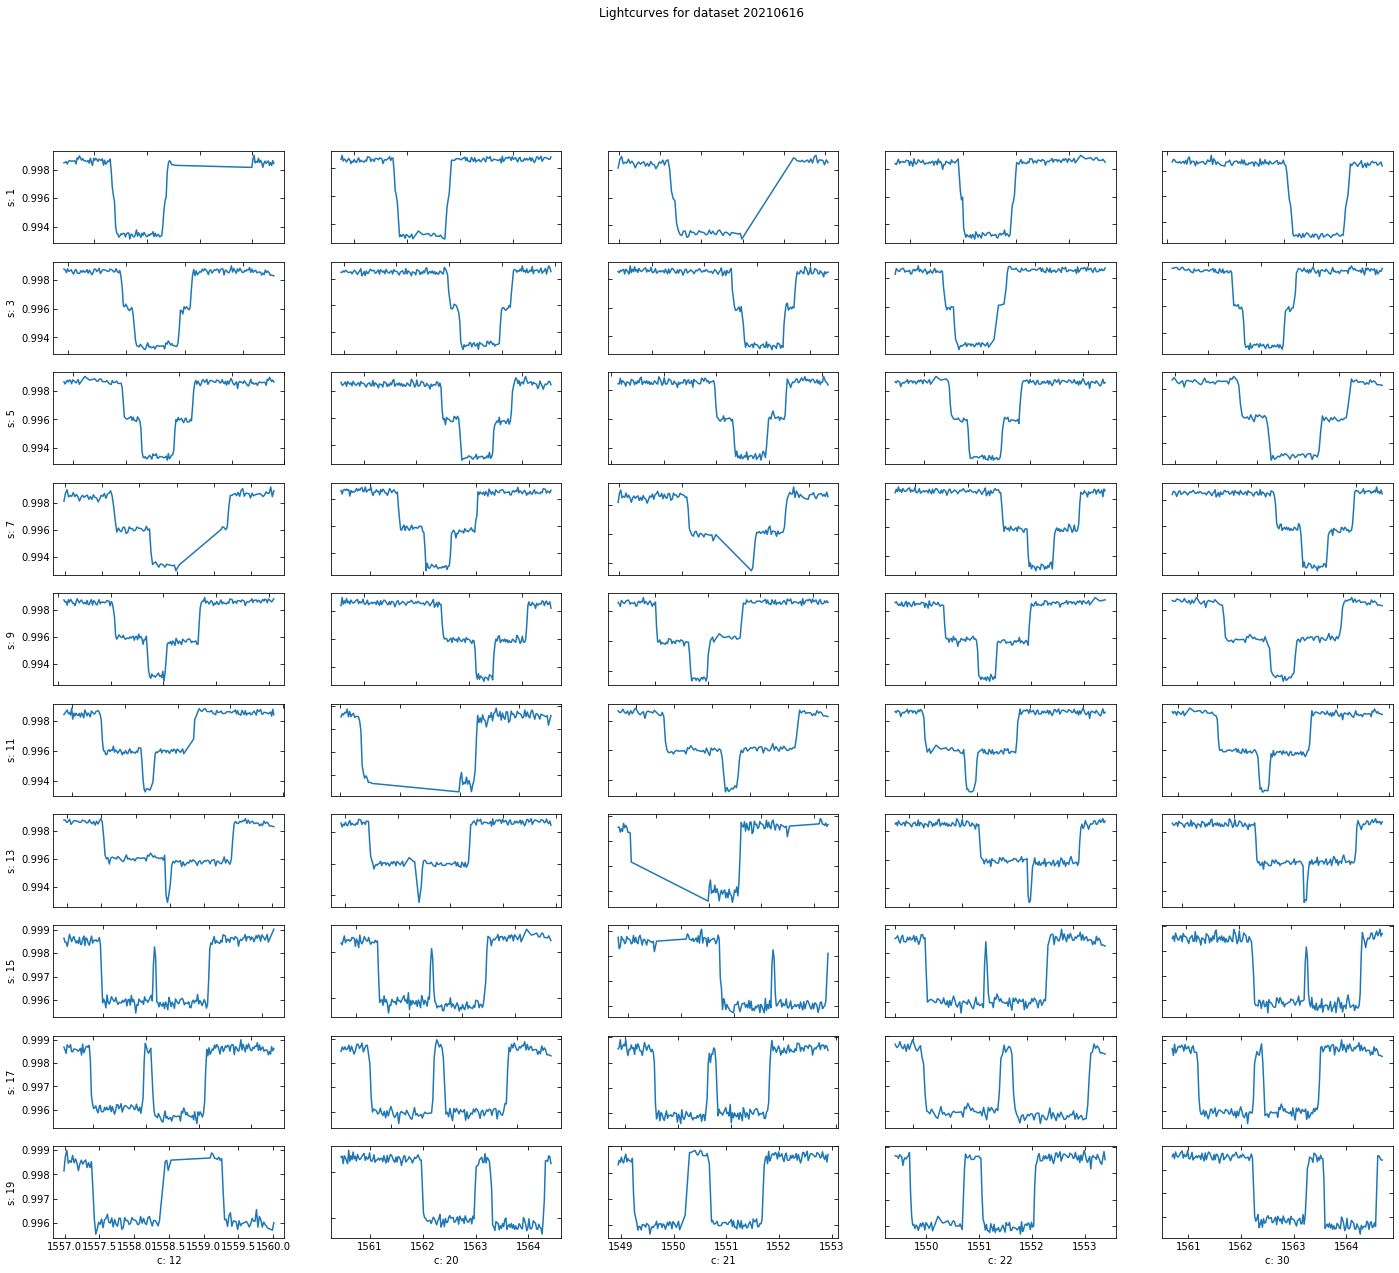

In [15]:


for k in range(2):
    fig, axs = plt.subplots(10,5, figsize = (24,20))
    for l in range(5):
        i = 5*k + l
        for j in range(10):
            prop = 0.512 * 1.25**j
            times,_,pcalc, midTime = loadTESSLC("tesslc_"+tessCurves[5])
            filename = "c"+str(int(i/3))+str(i%3)+"s"+str(2*j+1)+"k3"
            overlapTimes, planetLC = loadSignal(filename)
            pcaTimes, pcalc = injectSignal(times, pcalc, overlapTimes, planetLC, midTime)
            overlapTimes, sumLC = cutLightCurve(pcaTimes, pcalc, midTime - 2, midTime+2)
            axs[j][l].plot(overlapTimes, sumLC)
            axs[j][l].tick_params(direction = "in", which = "major", length = 4, top = True, right = True)
            axs[j][l].tick_params(direction = "in", which = "minor", length = 2, top = True, right = True)
            #axs[i][j].axis('off')
            axs[j][l].set_xlabel("c: "+ str(int(i/3))+str(i%3))
            axs[j][l].set_ylabel("s: "+str(2*j+1))
            for ax in axs.flat:
                ax.label_outer()
    fig.suptitle("Lightcurves for dataset 20210616")
    plt.show()

KeyboardInterrupt: 

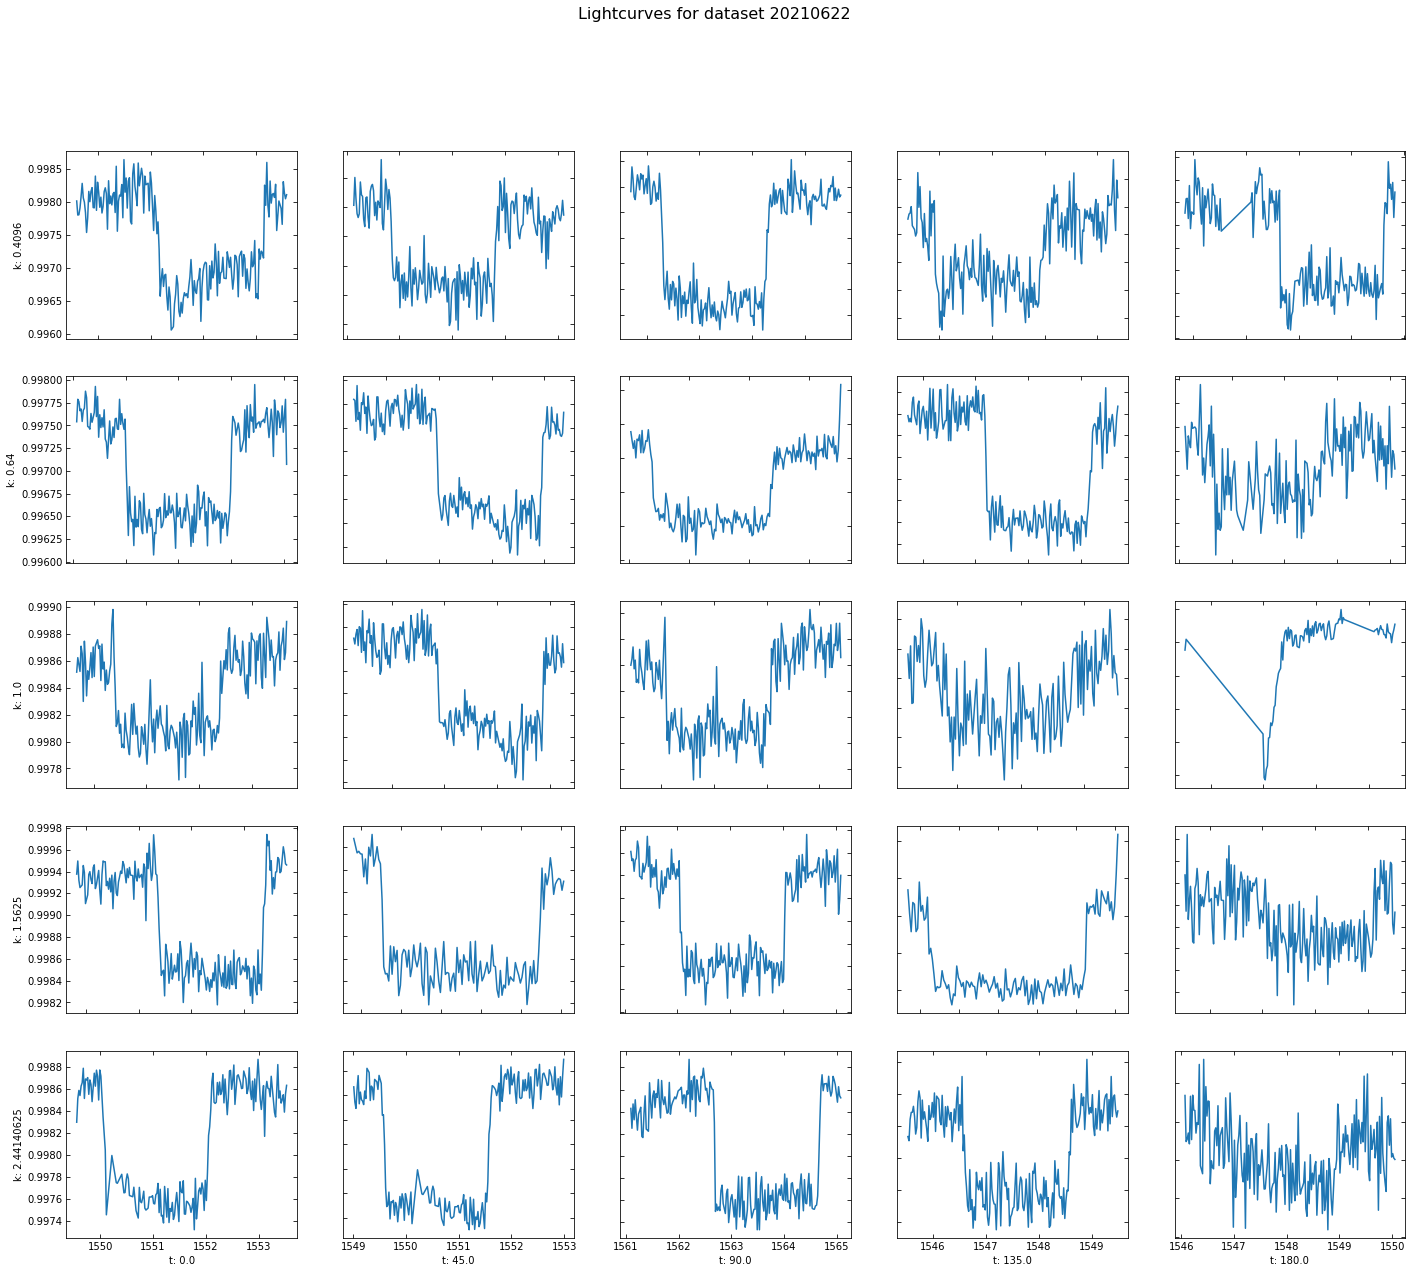

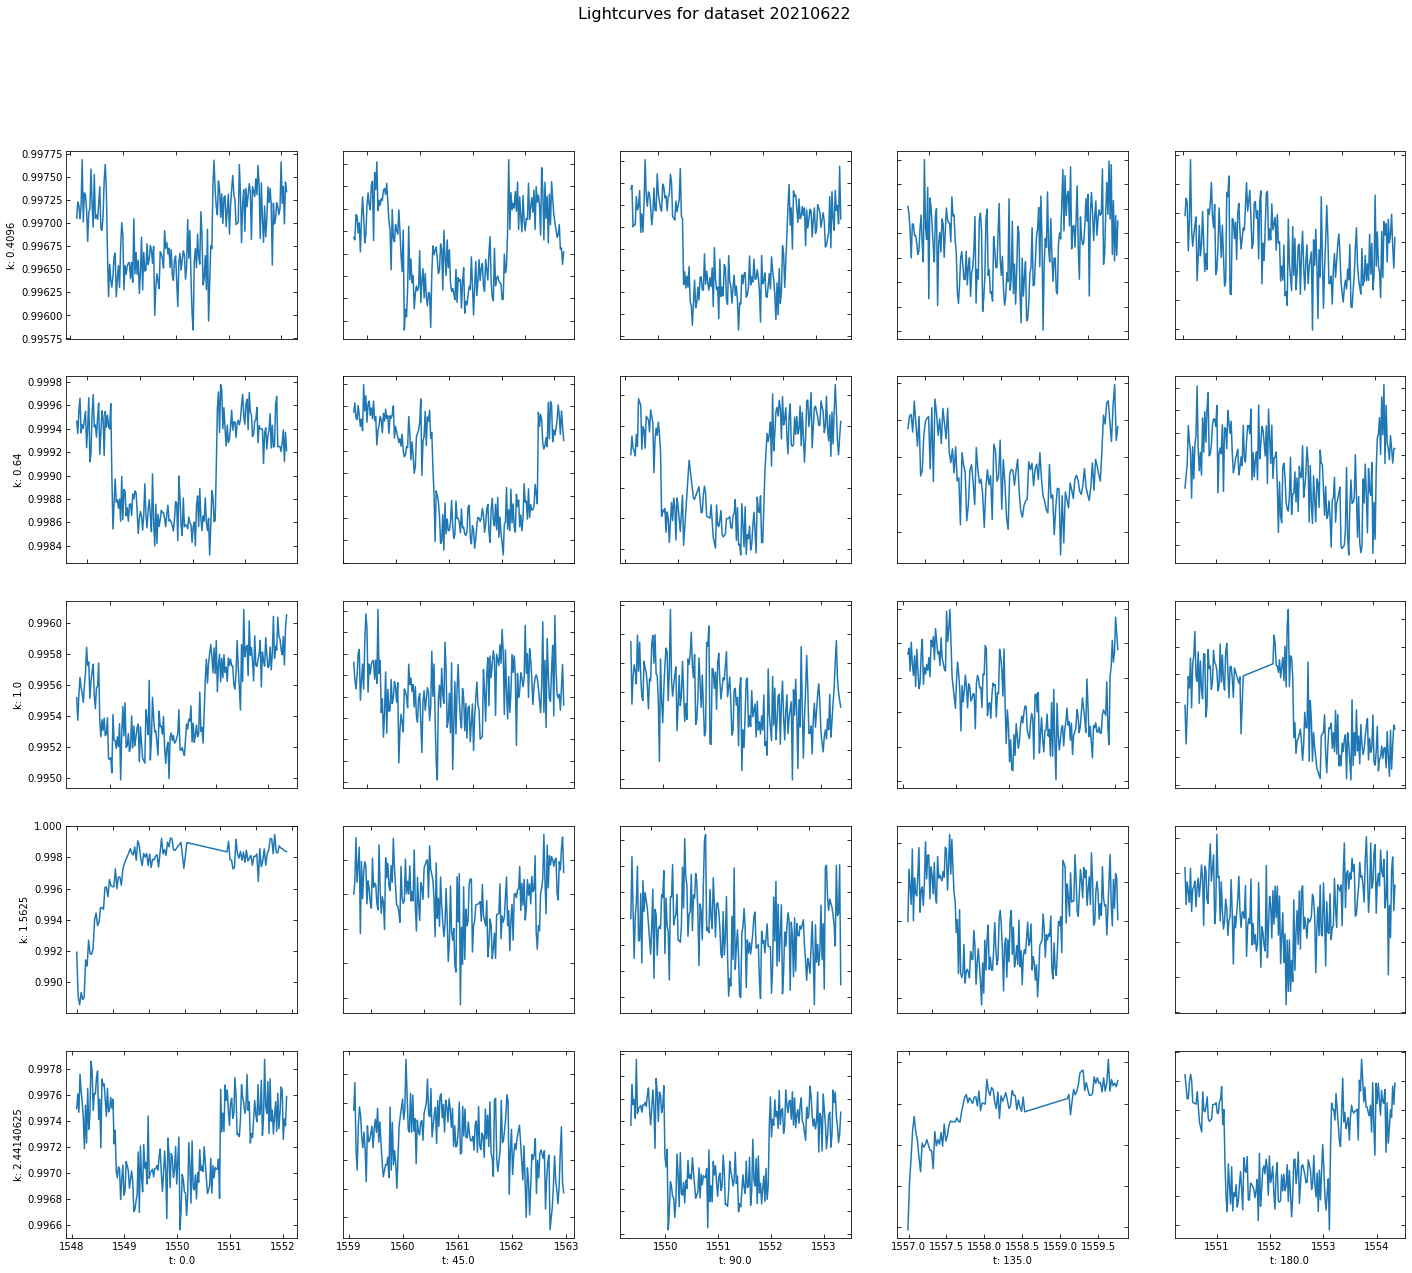

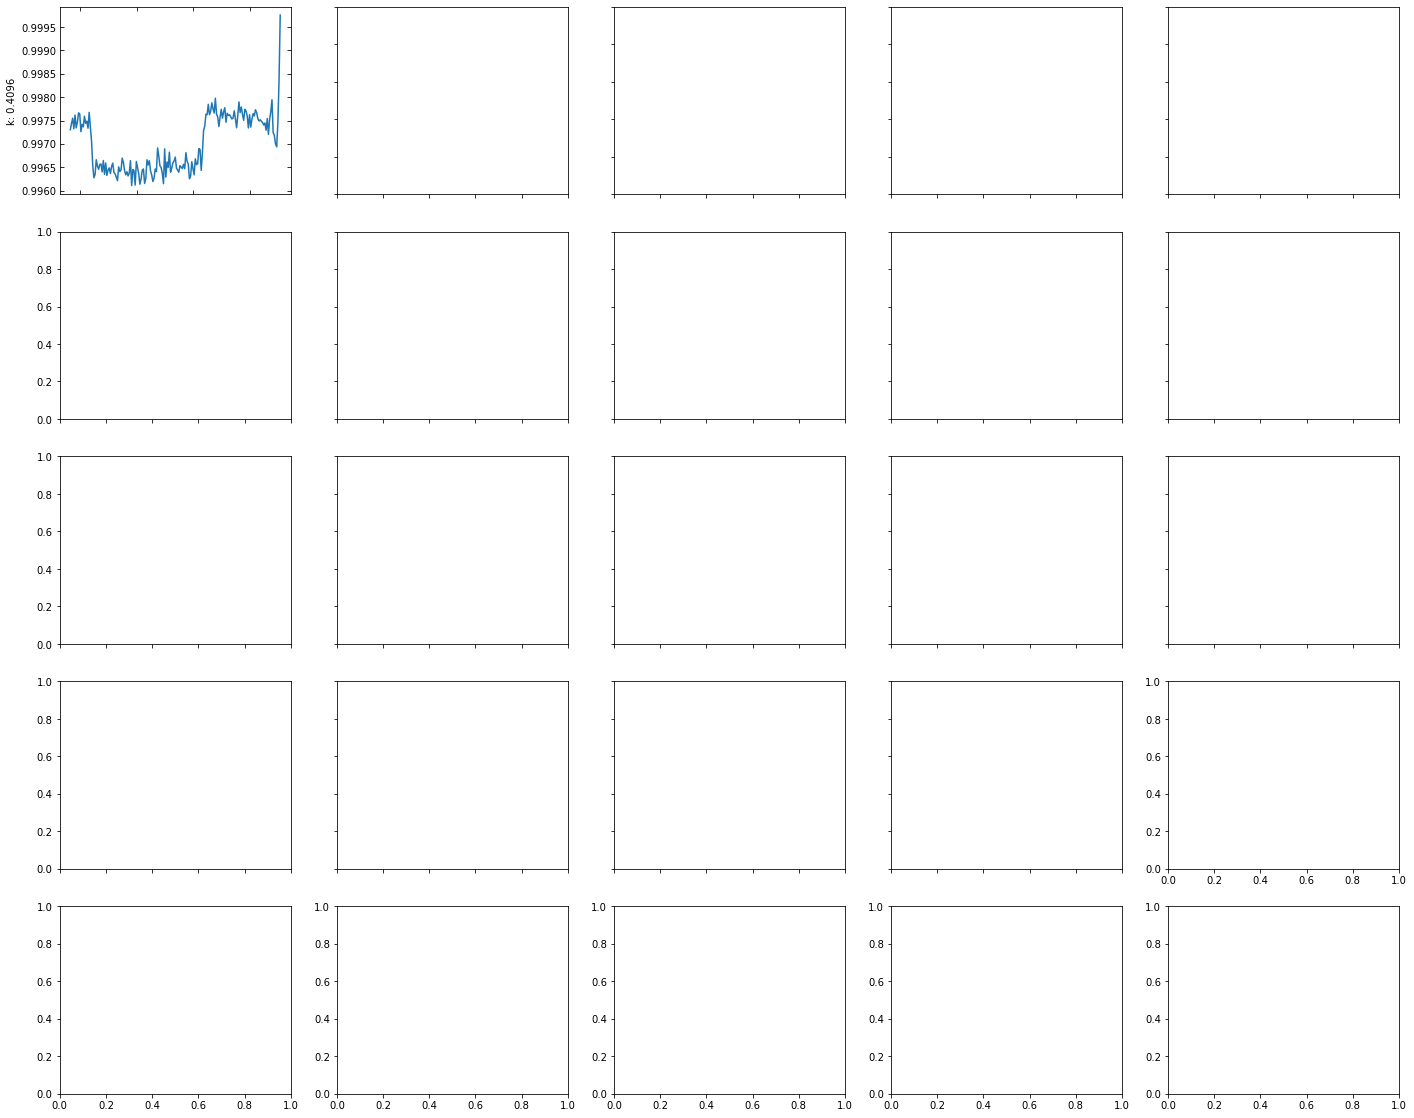

In [11]:
for i in range(5):
    for j in range(5):
        for k in range(5):
            fig, axs = plt.subplots(5,5, figsize = (24,20))
            for l in range(5):
                for m in range(5):
                    if k == 0:
                        n = 20
                    else:
                        n = k+2
                    prop = 0.4096 * 1.5625**l
                    velocity = 2**(i)
                    x = random.randint(0,len(tessCurves)-1)
                    times, corrlc, pcalc, midTime = loadTESSLC("tesslc_"+tessCurves[x])
                    filename = "n"+str(k+3)+"t"+str((m)*180/4)+"k"+str(prop)+"r"+str((j+1)*0.01)+"v"+str(velocity)
                    overlapTimes, planetLC = loadSignal(filename)
                    pcaTimes, pcalc = injectSignal(times, pcalc, overlapTimes, planetLC, midTime)
                    overlapTimes, sumLC = cutLightCurve(pcaTimes, pcalc, midTime-2, midTime+2)
                    depth = np.max(sumLC) - np.min(sumLC)
                    filename = "1"+str(n)+"2"+str(int(m*180/4))+"3"+str(l)+"4"+str(j+1)+"5"+str(velocity)+"0622"
                    #export("tesslc_"+tessCurves[x],filename, "20210622lookup",corrlc, pcalc,n,m*180/4,prop,depth,2/velocity,j+1)
                    axs[l][m].plot(overlapTimes, sumLC)
                    axs[l][m].tick_params(direction = "in", which = "major", length = 4, top = True, right = True)
                    axs[l][m].tick_params(direction = "in", which = "minor", length = 2, top = True, right = True)
                    axs[l][m].set_ylabel("k: "+str(prop))
                    axs[l][m].set_xlabel("t: "+str(m*180/4))
                    for ax in axs.flat:
                        ax.label_outer()
            fig.suptitle("Lightcurves for dataset 20210622", fontsize = 16)
            #fig.savefig("DataVisualization/20210622/n"+str(n)+"r"+str(j+1)+"v"+str(velocity)+".png")
            #plt.show()
        

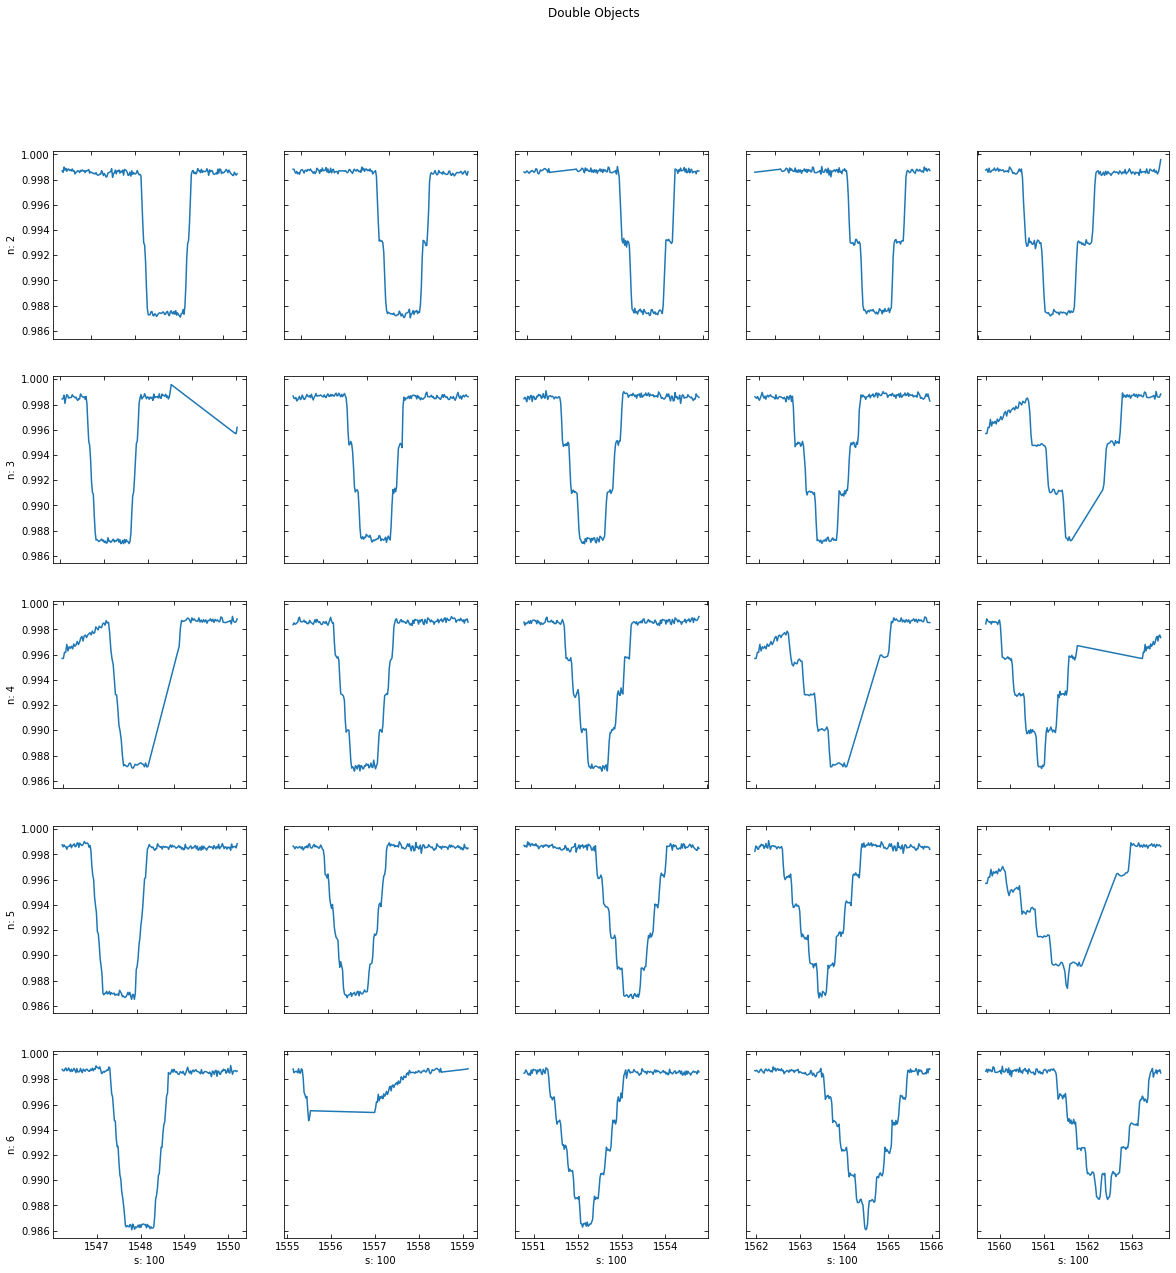

In [33]:
for k in range(5,6):
    fig, axs = plt.subplots(5,5, figsize = (20,20), sharex = False, sharey = True)
    ## Tis basically a switch
    if k == 5:
        n = 24
        rotation = 0
    elif k < 3:
        n = 3
        rotation = k*np.pi/2
    else:
        n = 4
        if k == 3:
            rotation = 0
        else:
            rotation = np.pi/4
    for i in range(5):
        for j in range(5):
            filename = "n"+str(n)+"s"+str(j+1)+'m'+str(i+2)+'v2'
            times, corrlc, pcalc, midTime = loadTESSLC("tesslc_"+tessCurves[0])
            overlapTimes, planetLC = loadSignal(filename)
            pcaTimes, pcalc = injectSignal(times, pcalc, overlapTimes, planetLC, midTime)
            overlapTimes, sumLC = cutLightCurve(pcaTimes, pcalc, midTime-2, midTime+2)
            axs[i][j].plot(overlapTimes, sumLC)
            axs[i][j].tick_params(direction = "in", which = "major", length = 4, top = True, right = True)
            axs[i][j].tick_params(direction = "in", which = "minor", length = 2, top = True, right = True)
            axs[i][j].set_ylabel("n: "+ str(i+2))
            axs[i][j].set_xlabel("s: "+str(100))
            for ax in axs.flat:
                ax.label_outer()
    fig.suptitle("Double Objects")
    plt.show()



    